# Estimating and Testing Distributions

This notebook illustrates basic descriptive statistics (means, std, skewness, kurtosis), histograms, the Jarque-Bera test (of normality), Q-Q plots and tests of the empirical distribution function (Kolmogorov-Smirnov). It uses the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl)  and [StatsBase.jl](https://github.com/JuliaStats/StatsBase.jl) packages.

You may also consider the [HypothesisTests.jl](https://github.com/JuliaStats/HypothesisTests.jl) package.

## Load Packages and Extra Functions

The key functions used in this notebook (`JarqueBeraTest()` and `KolSmirTest()`) are from the (local) `FinEcmt_OLS` module.

In [1]:
MyModulePath = joinpath(pwd(),"src")
!in(MyModulePath,LOAD_PATH) && push!(LOAD_PATH,MyModulePath)
using FinEcmt_OLS

In [2]:
#=
include(joinpath(pwd(),"src","FinEcmt_OLS.jl"))
using .FinEcmt_OLS
=#

In [3]:
using DelimitedFiles, Statistics, Distributions, StatsBase

In [4]:
using Plots
default(size = (480,320),fmt = :png)

# Load Data from a csv File

In [5]:
xx  = readdlm("Data/FFdFactors.csv",',',skipstart=1)
x   = xx[:,2]            #equity market excess returns
xx  = nothing

T   = size(x,1)
println("Sample size: $T")

Sample size: 15356


## Histograms

The next few cells shows some basic descriptive statistics for the variable `x` (US equity market excess return). 

In [6]:
μ = mean(x)
σ = std(x)
(xmin,xmax) = extrema(x)

printblue("Basic descriptive stats:\n")
xx = [μ,σ,xmin,xmax]
printmat(xx;rowNames=["μ","σ","min","max"])

Basic descriptive stats:

μ       0.026
σ       0.955
min   -17.440
max    11.350



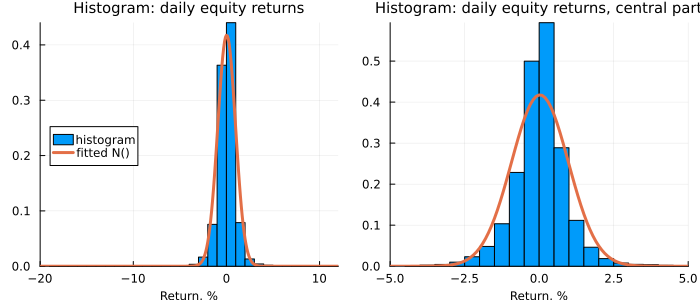

In [7]:
xGrid = -20:0.1:12
pdfX  = pdf.(Normal(μ,σ),xGrid)        #"Distributions.jl" wants σ, not σ^2

p1 = histogram( x,bins = -20:1:12,
                normalized = true,     #normalized to have area=1
                label = "histogram",
                legend = :left,
                xlim = (-20,12),
                title = "Histogram: daily equity returns",
                titlefontsize = 10,
                xlabel = "Return, %",
                guidefontsize = 8 )
plot!(xGrid,pdfX,linewidth=3,label="fitted N()")

p2 = histogram( x,bins = -5:0.5:5,
                normalized = true,
                legend = false,
                xlim = (-5,5),
                title = "Histogram: daily equity returns, central part",
                titlefontsize = 10,
                xlabel = "Return, %",
                guidefontsize = 8 )
plot!(xGrid,pdfX,linewidth=3,legend=false)

pAll = plot(p1,p2,layout=(1,2),size=(700,300))                  #set up subplots
display(pAll)

## Averaged Shifted Histogram

An averaged shifted histogram (ASH) first calculates histogram values over many bins and then averages across nearby bins. The output is a smoother histogram and something that comes very close to a kernel density estimate (see below).

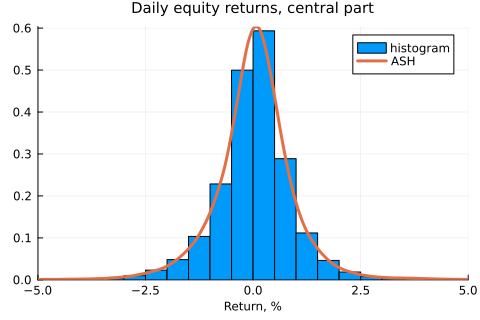

In [8]:
(ashPdf1, BinMid_ash1,_) = HistAsh(x,-5:0.5:5,21)   #21 shifts

p2 = histogram( x,bins = -5:0.5:5,
                normalized = true,
                label = "histogram",
                xlim = (-5,5),
                title = "Daily equity returns, central part",
                titlefontsize = 10,
                xlabel = "Return, %",
                guidefontsize = 8 )
plot!(BinMid_ash1,ashPdf1,linewidth=3,label="ASH")
display(p2)

## Q-Q Plot

The Q-Q plot shows the empirical quantiles against the theoretical quantiles (possibly from an estimated distribution). If the theoretical distribution is a good fit to the data, then the results should cluster closely around a 45 degree line.

### A Remark on the Code

The `quantile()` function for a distribution (from the `Distributions.jl` package) works slightly different from the `quantile()` function for data (from the `StatsBase.jl` package). In short,

- `quantile.(Normal(μ,σ),pval1)` calculates a vector of quantiles of a `Normal(μ,σ)` distribution.

- `quantile(x,pval1)` calculates a vector of empirical quantiles from the vector `x` (notice: no dot).

As an alternative, do `dist = fit(Normal,x); quantile.(dist,pval1)`

In [9]:
pval1 = 0.01:0.01:0.99                          #quantiles 0.01 to 0.99, to QQ plot
pval2 = [0.001:0.001:0.009;0.991:0.001:0.999]   #extreme quantiles

qEmp1 = quantile(x,pval1)                       #empirical quantiles, pval1; no dot
qEmp2 = quantile(x,pval2)                       #same, but for pval2
qN1   = quantile.(Normal(μ,σ),pval1)            #quantiles of N()
qN2   = quantile.(Normal(μ,σ),pval2);

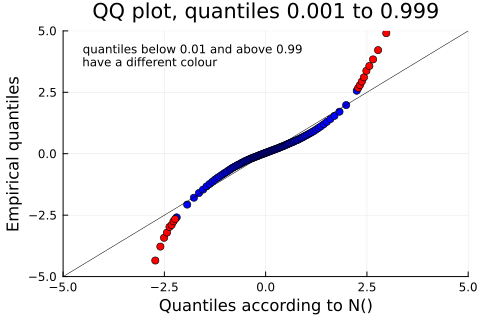

In [10]:
txt = text("quantiles below 0.01 and above 0.99\nhave a different colour",8,:left)

p1 = scatter( qN1,qEmp1,color=:blue,legend=false,
              xlim = (-5,5),
              ylim = (-5,5),
              title = "QQ plot, quantiles 0.001 to 0.999",
              xlabel = "Quantiles according to N()",
              ylabel = "Empirical quantiles",
              annotation = (-4.5,4,txt) )
scatter!(qN2,qEmp2,color=:red,legend=false)
plot!([-5,5],[-5,5],color=:black,linewidth=0.5)
display(p1)

## Skewness, Kurtosis and the Jarque-Bera Test

The `JarqueBeraTest()` function reports skewness, kurtosis and the B-J statistic.

In [11]:
@doc2 JarqueBeraTest

```
JarqueBeraTest(x)
```

Calculate the JB test for each column in a matrix. Reports `(skewness,kurtosis,JB)`.


In [12]:
#using CodeTracking
#println(@code_string JarqueBeraTest([1]))

In [13]:
(skewness,kurtosis,JB,pvals) = JarqueBeraTest(x)

#critval_BJ   = quantile(Chisq(2),0.9)                   #critical values
#critval_skew = quantile(Normal(0,sqrt(6/T)),0.9)
#critval_kurt = quantile(Normal(0,sqrt(24/T)),0.9)

printblue("More descriptive stats:\n")
xx = hcat([skewness;kurtosis-3;JB],collect(pvals))
printmat(xx;colNames=["Estimate","p-value"],
            rowNames=["skewness","excess kurtosis","Jarque-Bera"],width=15)

More descriptive stats:

                      Estimate        p-value
skewness                -0.519          0.000
excess kurtosis         16.166          0.000
Jarque-Bera         167896.608          0.000



## The Empirical Distribution Function and the Kolmogorov-Smirnov Test

The empirical distribution function (edf) shows the frequence of data points below a given threshold. The Kolmogorov-Smirnov (K-S) test is designed to investigate whether the edf differs from a theoretical (possibly estimated) cdf. It is implemented in the function `KolSmirTest()`.

An edf does essentially the following: rank all elements in `x` and divide the ranks by `T` to get relative ranks (0 to 1).

The K-S test finds the largest difference between the edf and the theoretical cdf, $D$. The 5% critical value of $\sqrt{T}D$ is 1.36.

In [14]:
@doc2 KolSmirTest

```
KolSmirTest(x1,TheoryCdf::Function)
```

Calculate the Kolmogorov-Smirnov test

### Output

  * `KSstat::Float64`:     KS test statistic
  * `xD::Number`:          x value with the largest diff beteen empirical and theoretical cdf


In [15]:
#println(@code_string KolSmirTest([1],cos))

In [16]:
edfx = ecdf(x)                   #construct the empirical distribution function
                                 #from the StatsBase.jl package
edfEmp = edfx(xGrid)                   #evaluate the empirical distribution function at xGrid
cdfN   = cdf.(Normal(μ,σ),xGrid);       #cdf of Normal(μ,σ), for comparison

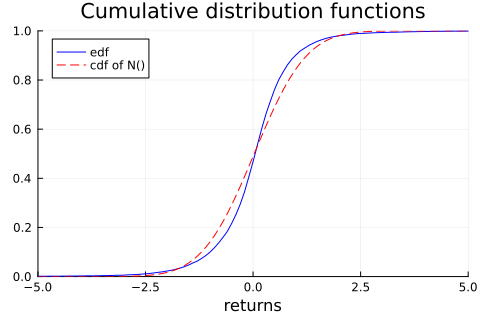

In [17]:
p1 = plot( xGrid,[edfEmp cdfN],
           label = ["edf" "cdf of N()"],
           linecolor = [:blue :red],
           linestyle = [:solid :dash],
           title = "Cumulative distribution functions",
           xlabel = "returns",
           xlim = (-5,5),
           ylim = (0,1) )
display(p1)

In [18]:
(KSstat,xD) = KolSmirTest(x,z->cdf(Normal(μ,σ),z))

printblue("Kolmogorov-Smirnov test:\n")
printmat([KSstat,1.36,xD];rowNames=["sqrt(T)*D","5% critval","at which x"])

Kolmogorov-Smirnov test:

sqrt(T)*D      9.941
5% critval     1.360
at which x    -0.400



# Kernel Density Estimate

The `KernelDensity()` function estimates the probability density function (pdf) by using a gaussian kernel. The bandwidth parameter (`h`) can be supplied by the caller, otherwise it defaults to the rule of thumb value $h=1.06\textrm{std}(x_t)/T^{0.2}$. In practice, the choice of kernel is less important that the choice of bandwidth.

The estimate of the pdf at value $x$ is
$\hat{f}\left(  x\right)  =\frac{1}{h}\frac{1}{T}\sum_{t=1}^{T}K(\frac{x_{t}-x}{h}),$

where $K()$ is one of the kernel functions listed below.

The function outputs both the estimate the estimate of $\textrm{pdf}(x)$, denoted `fx`, and its standard deviation, denoted `Stdfx`. The values are estimated at a grid of `x` values, supplied by the user.

As an alternative to this code, consider the [KernelDensity.jl](https://github.com/JuliaStats/KernelDensity.jl) package. Also, compare with the ASH used before.

In [19]:
using FinEcmt_KernelRegression

In [20]:
@doc2 KernelDensity

```
KernelDensity(x,xGrid,h=[],KernelFun=GaussianKernel)
```

Compute a kernel density estimate at each value of the grid `xGrid`, using the data in vector `x`. The bandwidth `h` can be specified (otherwise a default value is used). The kernel function defaults to a standard normal density function, but other choices are available.


In [21]:
#using CodeTracking
#println(@code_string KernelDensity([1],[1]))

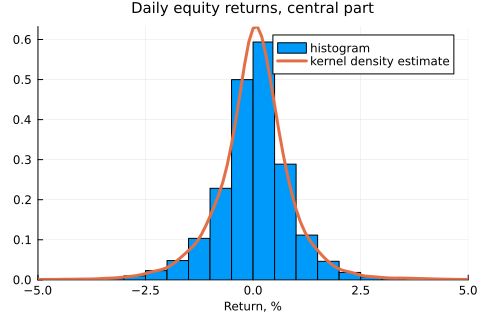

In [22]:
xGrid = -5:0.1:5                           #use many different values in the grid
(fx,Stdfx) = KernelDensity(x,xGrid)

p2 = histogram( x,bins = -5:0.5:5,
                normalized = true,
                label = "histogram",
                xlim = (-5,5),
                title = "Daily equity returns, central part",
                titlefontsize = 10,
                xlabel = "Return, %",
                guidefontsize = 8 )
plot!(xGrid,fx,linewidth=3,label="kernel density estimate")
display(p2)